In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
import time
import warnings
import joblib
import os
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture

warnings.filterwarnings('ignore')


In [9]:
df = pd.read_csv("cicids2017_cleaned.csv")


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520751 entries, 0 to 2520750
Data columns (total 53 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Length of Fwd Packets  int64  
 4   Fwd Packet Length Max        int64  
 5   Fwd Packet Length Min        int64  
 6   Fwd Packet Length Mean       float64
 7   Fwd Packet Length Std        float64
 8   Bwd Packet Length Max        int64  
 9   Bwd Packet Length Min        int64  
 10  Bwd Packet Length Mean       float64
 11  Bwd Packet Length Std        float64
 12  Flow Bytes/s                 float64
 13  Flow Packets/s               float64
 14  Flow IAT Mean                float64
 15  Flow IAT Std                 float64
 16  Flow IAT Max                 int64  
 17  Flow IAT Min                 int64  
 18  Fwd IAT Total                int64  
 19  

In [12]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Length of Fwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'Average Packet Size', 'Subflow Fwd Bytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_p

In [2]:
sample_size = 10000
if df.shape[0] > sample_size:
    df = df.sample(n=sample_size, random_state=42)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

if 'Attack Type' in df.columns:
    df['Label_binary'] = df['Attack Type'].apply(lambda x: 0 if x == 'Normal Traffic' or x == 'BENIGN' else 1)
    X = df.drop(['Attack Type', 'Label_binary'], axis=1)
elif 'Label' in df.columns:
    df['Label_binary'] = df['Label'].apply(lambda x: 0 if x == 'Normal Traffic' or x == 'BENIGN' else 1)
    X = df.drop(['Label', 'Label_binary'], axis=1)
else:
    X = df.drop(['Label_binary'], axis=1)

y = df['Label_binary']
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


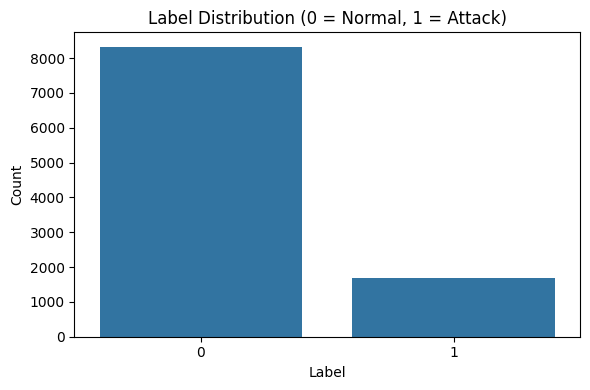

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

df_viz = df.sample(n=10000, random_state=42).copy()

if 'Label_binary' not in df_viz.columns and 'Attack Type' in df_viz.columns:
    df_viz['Label_binary'] = df_viz['Attack Type'].apply(lambda x: 0 if x in ['Normal Traffic', 'BENIGN'] else 1)

# --- 1. Label Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Label_binary', data=df_viz)
plt.title("Label Distribution (0 = Normal, 1 = Attack)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [3]:
models = [
    (IsolationForest(n_estimators=50, max_samples=256, contamination=0.1, random_state=42, n_jobs=2), "Isolation Forest"),
    (LocalOutlierFactor(n_neighbors=10, contamination=0.1, novelty=True, n_jobs=2), "Local Outlier Factor"),
    (OneClassSVM(kernel='linear', gamma='scale', nu=0.1), "One-Class SVM"),
    (EllipticEnvelope(contamination=0.1, random_state=42, support_fraction=0.8), "Elliptic Envelope"),
    (MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=1024, max_iter=100), "K-Means"),
    (GaussianMixture(n_components=2, covariance_type='diag', random_state=42, max_iter=100, tol=0.01), "Gaussian Mixture")
]


In [5]:
results = []

# Reset index once to simplify downstream access
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

for model, name in models:
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    try:
        if name in ["Isolation Forest", "Local Outlier Factor", "One-Class SVM", "Elliptic Envelope", "K-Means", "Gaussian Mixture"]:
            normal_indices = y_train[y_train == 0].index
            sampled_indices = np.random.choice(normal_indices, size=min(10000, len(normal_indices)), replace=False)
            X_train_sample = X_train.iloc[sampled_indices]
            model.fit(X_train_sample)

            test_sample_size = min(20000, X_test.shape[0])
            X_test_sample = X_test.iloc[:test_sample_size]
            y_test_sample = y_test.iloc[:test_sample_size]

            y_pred = model.predict(X_test_sample)
            if np.any(np.isin(y_pred, [-1, 1])):
                y_pred = np.where(y_pred == -1, 1, 0)
            decision_scores = model.decision_function(X_test_sample) if hasattr(model, 'decision_function') else None

        else:
            train_sample_size = min(20000, X_train.shape[0])
            train_indices = np.random.choice(X_train.index, size=train_sample_size, replace=False)
            X_train_sample = X_train.iloc[train_indices]
            y_train_sample = y_train.iloc[train_indices]
            model.fit(X_train_sample, y_train_sample)

            test_sample_size = min(20000, X_test.shape[0])
            X_test_sample = X_test.iloc[:test_sample_size]
            y_test_sample = y_test.iloc[:test_sample_size]

            y_pred = model.predict(X_test_sample)
            decision_scores = model.predict_proba(X_test_sample)[:, 1] if hasattr(model, 'predict_proba') else None

        duration = time.time() - start_time
        print(f"{name} trained in {duration:.2f} seconds")

        accuracy = accuracy_score(y_test_sample, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_sample, y_pred, average='binary')
        auc = roc_auc_score(y_test_sample, decision_scores) if decision_scores is not None else None

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc,
            'Training Time (s)': duration
        })

    except Exception as e:
        print(f"Error training {name}: {e}")



Training Isolation Forest...
Isolation Forest trained in 0.12 seconds

Training Local Outlier Factor...
Local Outlier Factor trained in 0.40 seconds

Training One-Class SVM...
One-Class SVM trained in 0.37 seconds

Training Elliptic Envelope...
Elliptic Envelope trained in 1.27 seconds

Training K-Means...
K-Means trained in 0.07 seconds

Training Gaussian Mixture...
Gaussian Mixture trained in 0.06 seconds


In [6]:
results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False)
print(results_df)


                  Model  Accuracy  Precision    Recall  F1 Score       AUC  \
2         One-Class SVM  0.867000   0.588034  0.685259  0.632935  0.264511   
1  Local Outlier Factor  0.863667   0.582888  0.651394  0.615240  0.124311   
0      Isolation Forest  0.867000   0.600000  0.615538  0.607670  0.177631   
3     Elliptic Envelope  0.823000   0.460705  0.338645  0.390356  0.181380   
4               K-Means  0.832667   0.000000  0.000000  0.000000       NaN   
5      Gaussian Mixture  0.832667   0.000000  0.000000  0.000000       NaN   

   Training Time (s)  
2           0.373095  
1           0.400063  
0           0.115656  
3           1.272385  
4           0.070172  
5           0.059352  


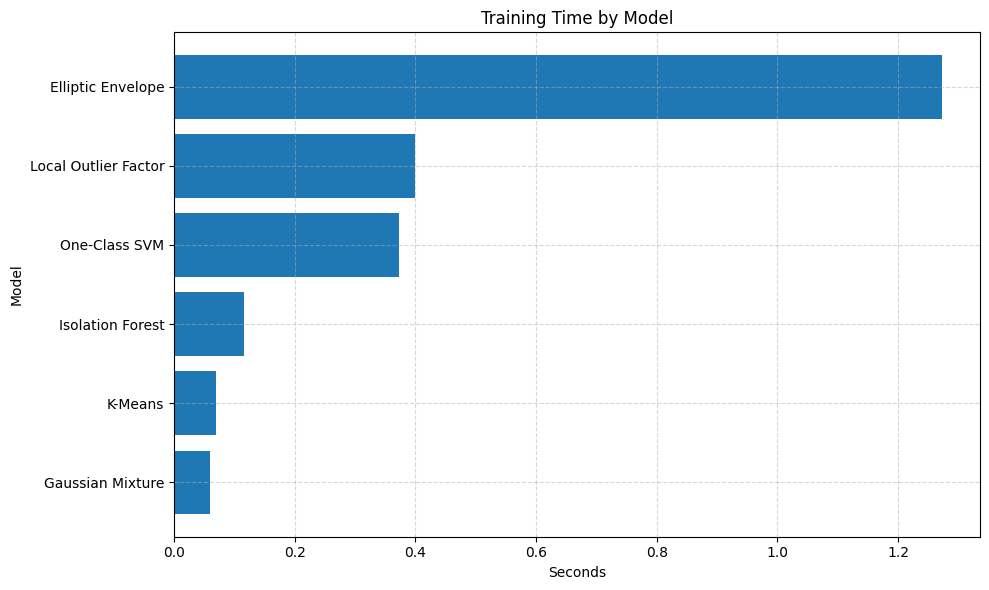

In [17]:
plt.figure(figsize=(10, 6))
results_df_sorted = results_df.sort_values('Training Time (s)', ascending=True)
plt.barh(results_df_sorted['Model'], results_df_sorted['Training Time (s)'])
plt.title('Training Time by Model')
plt.xlabel('Seconds')
plt.ylabel('Model')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [31]:
import joblib
import os
import numpy as np

# Ensure output directory exists
os.makedirs("saved_models", exist_ok=True)

# Loop through each model
for model, name in models:
    print(f"\n Training: {name}")
    try:
        # For unsupervised models, train on normal data only
        if name in ["Isolation Forest", "Local Outlier Factor", "One-Class SVM", "Elliptic Envelope", "K-Means", "Gaussian Mixture"]:
            normal_indices = y_train[y_train == 0].index
            sampled_indices = np.random.choice(normal_indices, size=min(10000, len(normal_indices)), replace=False)
            X_train_sample = X_train.iloc[sampled_indices]
            model.fit(X_train_sample)
        else:
            model.fit(X_train, y_train)

        # Save the trained model
        filename = name.lower().replace(" ", "_").replace("-", "") + ".pkl"
        filepath = os.path.join("saved_models", filename)
        joblib.dump(model, filepath)
        print(f" Model saved: {filepath}")
        
    except Exception as e:
        print(f" Error training/saving {name}: {e}")



 Training: Isolation Forest
 Model saved: saved_models\isolation_forest.pkl

 Training: Local Outlier Factor
 Model saved: saved_models\local_outlier_factor.pkl

 Training: One-Class SVM
 Model saved: saved_models\oneclass_svm.pkl

 Training: Elliptic Envelope
 Model saved: saved_models\elliptic_envelope.pkl

 Training: K-Means
 Model saved: saved_models\kmeans.pkl

 Training: Gaussian Mixture
 Model saved: saved_models\gaussian_mixture.pkl
